In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec
from models import CNNClassifier, RNNClassifier, GRUClassifier, LSTMClassifier, TClassifier
from training_function import training
from config_dataset import custom_dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sequence_length = 20
batch_size = 32
embedding_dim = 300
hidden_dim = 8

In [4]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_test, style1_test, style2_test = custom_dataset('divina_commedia.txt',
                                                                                                                                                        'uno_nessuno_e_i_malavoglia.txt',
                                                                                                                                                        'lo_cunto_de_li_cunti.txt',
                                                                                                                                                        sequence_length,
                                                                                                                                                        embedding_dim,
                                                                                                                                                        batch_size,
                                                                                                                                                        0.8)
print('len train loader: ', len(train_loader))
print('len val loader: ', len(val_loader))
print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

len train loader:  352
len val loader:  44
total number of training samples:  11248
total number of validation samples:  1405
vocab size:  26607


In [12]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_test, style1_test, style2_test = custom_dataset('inferno.txt',
                                                                                                                                                        'purgatorio.txt',
                                                                                                                                                        'paradiso.txt',
                                                                                                                                                        sequence_length,
                                                                                                                                                        embedding_dim,
                                                                                                                                                        batch_size,
                                                                                                                                                        0.8)
print('len train loader: ', len(train_loader))
print('len val loader: ', len(val_loader))
print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

len train loader:  363
len val loader:  46
total number of training samples:  11606
total number of validation samples:  1450
vocab size:  12762


# CNN Classifier

In [5]:
cnn_classifier = CNNClassifier(embedding_matrix, 3, 3, [3,3,3])

In [6]:
classifier_params = sum(p.numel() for p in cnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8139


 12%|█▎        | 1/8 [00:02<00:14,  2.09s/it]

====> Epoch: 1 Average train loss: 0.0213, Average val loss: 0.0183


 25%|██▌       | 2/8 [00:04<00:12,  2.03s/it]

====> Epoch: 2 Average train loss: 0.0182, Average val loss: 0.0179


 38%|███▊      | 3/8 [00:05<00:09,  1.89s/it]

====> Epoch: 3 Average train loss: 0.0179, Average val loss: 0.0179


 50%|█████     | 4/8 [00:07<00:07,  1.79s/it]

====> Epoch: 4 Average train loss: 0.0177, Average val loss: 0.0178


 62%|██████▎   | 5/8 [00:09<00:05,  1.71s/it]

====> Epoch: 5 Average train loss: 0.0176, Average val loss: 0.0177


 75%|███████▌  | 6/8 [00:10<00:03,  1.79s/it]

====> Epoch: 6 Average train loss: 0.0176, Average val loss: 0.0178


 88%|████████▊ | 7/8 [00:12<00:01,  1.79s/it]

====> Epoch: 7 Average train loss: 0.0175, Average val loss: 0.0177


100%|██████████| 8/8 [00:14<00:00,  1.79s/it]

====> Epoch: 8 Average train loss: 0.0175, Average val loss: 0.0177


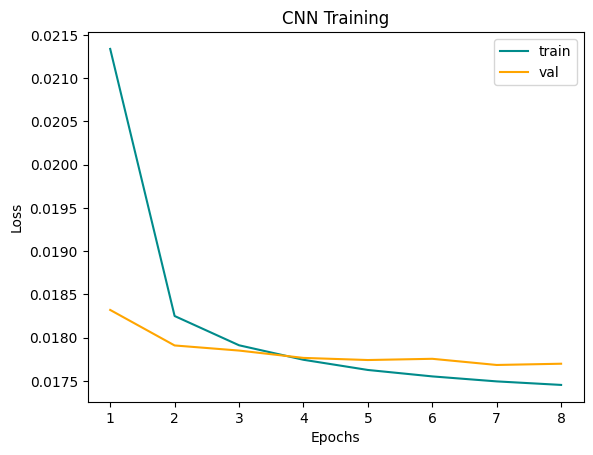

In [8]:
train_losses = training(cnn_classifier, train_loader, val_loader, 8, 4e-4, 'CNN Training')

### Examples with CNN 

In [143]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = cnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  2 ,  Napoletano
Predicted Style:  2 with probability:  57.61168599128723 %
Input sequence: 
 io non tanto averraggio tormiento de scrastareme da sto nigro cuorpo quanto de scantoniareme da ssa bella perzona cossì dicendo


# CNN Classifier Accuracy

In [9]:
with torch.no_grad():
    pred_labels = cnn_classifier(style0_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

dante_accuracy = 0
for lab in pred_labels:
    if lab.item() == 0:
        dante_accuracy +=1

dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.9752212389380531


In [10]:
with torch.no_grad():
    pred_labels = cnn_classifier(style1_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

italian_accuracy = 0
for lab in pred_labels:
    if lab.item() == 1:
        italian_accuracy +=1

italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Italian: ', italian_accuracy)

Accuracy predicting Italian:  0.9946902654867257


In [11]:
with torch.no_grad():
    pred_labels = cnn_classifier(style2_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

neapolitan_accuracy = 0
for lab in pred_labels:
    if lab.item() == 2:
        neapolitan_accuracy +=1

neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Neapolitan: ', neapolitan_accuracy)

Accuracy predicting Neapolitan:  0.9964028776978417


In [12]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall CNN Accuracy: ', overall_accuracy)

Overall CNN Accuracy:  0.9887714607075401


# RNN Classifier

In [20]:
rnn_classifier = RNNClassifier(embedding_matrix, hidden_dim, 1)

In [21]:
classifier_params = sum(p.numel() for p in rnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3107


 10%|█         | 1/10 [00:01<00:09,  1.02s/it]

====> Epoch: 1 Average train loss: 0.0326, Average val loss: 0.0278


 20%|██        | 2/10 [00:02<00:08,  1.05s/it]

====> Epoch: 2 Average train loss: 0.0259, Average val loss: 0.0238


 30%|███       | 3/10 [00:03<00:07,  1.00s/it]

====> Epoch: 3 Average train loss: 0.0224, Average val loss: 0.0208


 40%|████      | 4/10 [00:03<00:05,  1.01it/s]

====> Epoch: 4 Average train loss: 0.0192, Average val loss: 0.0182


 50%|█████     | 5/10 [00:04<00:04,  1.05it/s]

====> Epoch: 5 Average train loss: 0.0163, Average val loss: 0.0158


 60%|██████    | 6/10 [00:05<00:03,  1.07it/s]

====> Epoch: 6 Average train loss: 0.0137, Average val loss: 0.0135


 70%|███████   | 7/10 [00:06<00:02,  1.09it/s]

====> Epoch: 7 Average train loss: 0.0111, Average val loss: 0.0104


 80%|████████  | 8/10 [00:07<00:01,  1.11it/s]

====> Epoch: 8 Average train loss: 0.0084, Average val loss: 0.0078


 90%|█████████ | 9/10 [00:08<00:00,  1.06it/s]

====> Epoch: 9 Average train loss: 0.0064, Average val loss: 0.0060


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

====> Epoch: 10 Average train loss: 0.0051, Average val loss: 0.0054


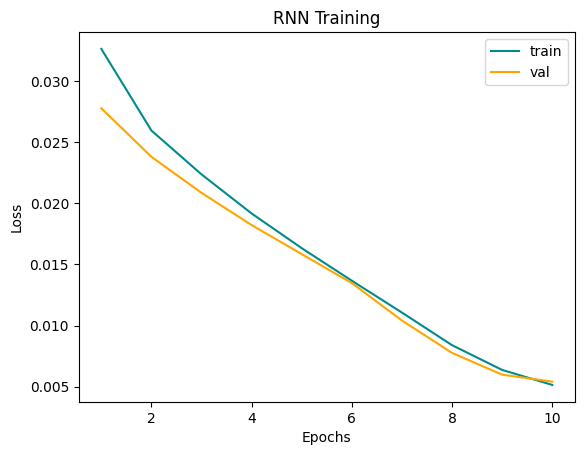

In [22]:
train_losses = training(rnn_classifier, train_loader, val_loader, 10, 4e-4, 'RNN Training')

In [153]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = rnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  2 ,  Napoletano
Predicted Style:  2 with probability:  96.19741439819336 %
Input sequence: 
 ve la dicere comme sta restava de mala voglia a sto pajese ma pocca lo cielo me l ha mannata


# RNN Classifier Accuracy

In [23]:
dante_accuracy = 0
with torch.no_grad():
    for data in style0_test:
        pred_label = rnn_classifier(data)
        if torch.argmax(pred_label).item() == 0:
            dante_accuracy += 1
    
dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.9486725663716814


In [24]:
italian_accuracy = 0
with torch.no_grad():
    for data in style1_test:
        pred_label = rnn_classifier(data)
        if torch.argmax(pred_label).item() == 1:
            italian_accuracy += 1
    
italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Dante: ', italian_accuracy)

Accuracy predicting Dante:  0.9610619469026549


In [25]:
neapolitan_accuracy = 0
with torch.no_grad():
    for data in style2_test:
        pred_label = rnn_classifier(data)
        if torch.argmax(pred_label).item() == 2:
            neapolitan_accuracy += 1
    
neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Dante: ', neapolitan_accuracy)

Accuracy predicting Dante:  0.9280575539568345


In [26]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall RNN Accuracy: ', overall_accuracy)

Overall RNN Accuracy:  0.9459306890770569


# GRU Classifier

In [55]:
gru_classifier = GRUClassifier(embedding_matrix, hidden_dim, 1)

In [56]:
classifier_params = sum(p.numel() for p in gru_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8067


 10%|█         | 1/10 [00:01<00:17,  1.92s/it]

====> Epoch: 1 Average train loss: 0.0283, Average val loss: 0.0224


 20%|██        | 2/10 [00:03<00:15,  1.92s/it]

====> Epoch: 2 Average train loss: 0.0180, Average val loss: 0.0145


 30%|███       | 3/10 [00:05<00:12,  1.81s/it]

====> Epoch: 3 Average train loss: 0.0111, Average val loss: 0.0093


 40%|████      | 4/10 [00:07<00:10,  1.77s/it]

====> Epoch: 4 Average train loss: 0.0069, Average val loss: 0.0063


 50%|█████     | 5/10 [00:08<00:08,  1.73s/it]

====> Epoch: 5 Average train loss: 0.0046, Average val loss: 0.0046


 60%|██████    | 6/10 [00:10<00:07,  1.75s/it]

====> Epoch: 6 Average train loss: 0.0033, Average val loss: 0.0036


 70%|███████   | 7/10 [00:12<00:05,  1.74s/it]

====> Epoch: 7 Average train loss: 0.0026, Average val loss: 0.0031


 80%|████████  | 8/10 [00:14<00:03,  1.72s/it]

====> Epoch: 8 Average train loss: 0.0020, Average val loss: 0.0028


 90%|█████████ | 9/10 [00:15<00:01,  1.70s/it]

====> Epoch: 9 Average train loss: 0.0016, Average val loss: 0.0030


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

====> Epoch: 10 Average train loss: 0.0013, Average val loss: 0.0025


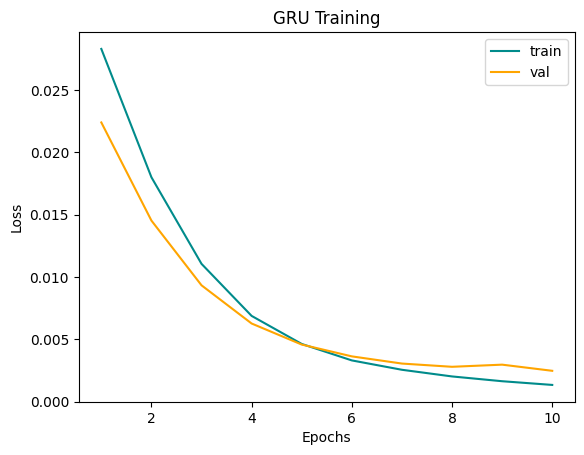

In [57]:
train_losses = training(gru_classifier, train_loader, val_loader, 10, 4e-4, 'GRU Training')

In [154]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = gru_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.8595654964447 %
Input sequence: 
 parente già era l caponsacco nel mercato disceso giù da fiesole e già era buon cittadino giuda e infangato io


# GRU Classifier Accuracy

In [58]:
dante_accuracy = 0
with torch.no_grad():
    for data in style0_test:
        pred_label = gru_classifier(data)
        if torch.argmax(pred_label, dim=-1).item() == 0:
            dante_accuracy += 1
    
dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.9787610619469026


In [59]:
italian_accuracy = 0
with torch.no_grad():
    for data in style1_test:
        pred_label = gru_classifier(data)
        if torch.argmax(pred_label, dim = -1).item() == 1:
            italian_accuracy += 1
    
italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Dante: ', italian_accuracy)

Accuracy predicting Dante:  0.9823008849557522


In [60]:
neapolitan_accuracy = 0
with torch.no_grad():
    for data in style2_test:
        pred_label = gru_classifier(data)
        if torch.argmax(pred_label, dim = -1).item() == 2:
            neapolitan_accuracy += 1
    
neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Dante: ', neapolitan_accuracy)

Accuracy predicting Dante:  0.9820143884892086


In [61]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall GRU Accuracy: ', overall_accuracy)

Overall GRU Accuracy:  0.9810254451306212


# LSTM Classifier

In [62]:
lstm_classifier = LSTMClassifier(embedding_matrix, hidden_dim, 1)

In [63]:
classifier_params = sum(p.numel() for p in lstm_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  10547


 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

====> Epoch: 1 Average train loss: 0.0295, Average val loss: 0.0203


 20%|██        | 2/10 [00:02<00:08,  1.03s/it]

====> Epoch: 2 Average train loss: 0.0105, Average val loss: 0.0049


 30%|███       | 3/10 [00:02<00:06,  1.04it/s]

====> Epoch: 3 Average train loss: 0.0036, Average val loss: 0.0027


 40%|████      | 4/10 [00:03<00:05,  1.10it/s]

====> Epoch: 4 Average train loss: 0.0022, Average val loss: 0.0021


 50%|█████     | 5/10 [00:04<00:04,  1.15it/s]

====> Epoch: 5 Average train loss: 0.0016, Average val loss: 0.0018


 60%|██████    | 6/10 [00:05<00:03,  1.19it/s]

====> Epoch: 6 Average train loss: 0.0012, Average val loss: 0.0019


 70%|███████   | 7/10 [00:06<00:02,  1.21it/s]

====> Epoch: 7 Average train loss: 0.0010, Average val loss: 0.0015


 80%|████████  | 8/10 [00:06<00:01,  1.23it/s]

====> Epoch: 8 Average train loss: 0.0009, Average val loss: 0.0017


 90%|█████████ | 9/10 [00:07<00:00,  1.19it/s]

====> Epoch: 9 Average train loss: 0.0007, Average val loss: 0.0017


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]

====> Epoch: 10 Average train loss: 0.0006, Average val loss: 0.0016


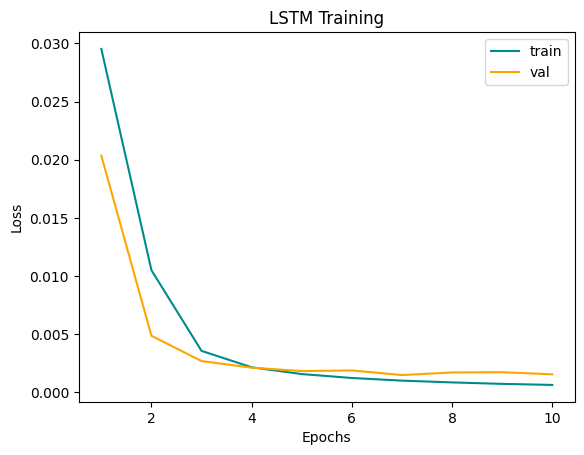

In [64]:
train_losses = training(lstm_classifier, train_loader, val_loader, 10, 4e-4, 'LSTM Training')

In [159]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = lstm_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.85785484313965 %
Input sequence: 
 menti non capere in triangol due ottusi così vedi le cose contingenti anzi che sieno in sè mirando il punto


In [65]:
dante_accuracy = 0
with torch.no_grad():
    for data in style0_test:
        pred_label = lstm_classifier(data)
        if torch.argmax(pred_label).item() == 0:
            dante_accuracy += 1
    
dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.9893805309734514


In [66]:
italian_accuracy = 0
with torch.no_grad():
    for data in style1_test:
        pred_label = lstm_classifier(data)
        if torch.argmax(pred_label).item() == 1:
            italian_accuracy += 1
    
italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Dante: ', italian_accuracy)

Accuracy predicting Dante:  0.9893805309734514


In [67]:
neapolitan_accuracy = 0
with torch.no_grad():
    for data in style2_test:
        pred_label = lstm_classifier(data)
        if torch.argmax(pred_label).item() == 2:
            neapolitan_accuracy += 1
    
neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Dante: ', neapolitan_accuracy)

Accuracy predicting Dante:  0.9856115107913669


In [68]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall LSTM Accuracy: ', overall_accuracy)

Overall LSTM Accuracy:  0.9881241909127566


# Transformer Classifier

In [48]:
t_classifier = TClassifier(embedding_matrix, hidden_dim, 1)

In [49]:
classifier_params = sum(p.numel() for p in t_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3188599


 20%|██        | 1/5 [00:15<01:03, 15.91s/it]

====> Epoch: 1 Average train loss: 0.0016, Average val loss: 0.0007


 40%|████      | 2/5 [00:31<00:47, 15.76s/it]

====> Epoch: 2 Average train loss: 0.0006, Average val loss: 0.0007


 60%|██████    | 3/5 [00:47<00:31, 15.67s/it]

====> Epoch: 3 Average train loss: 0.0002, Average val loss: 0.0009


 80%|████████  | 4/5 [01:02<00:15, 15.70s/it]

====> Epoch: 4 Average train loss: 0.0001, Average val loss: 0.0011


100%|██████████| 5/5 [01:18<00:00, 15.71s/it]

====> Epoch: 5 Average train loss: 0.0001, Average val loss: 0.0013


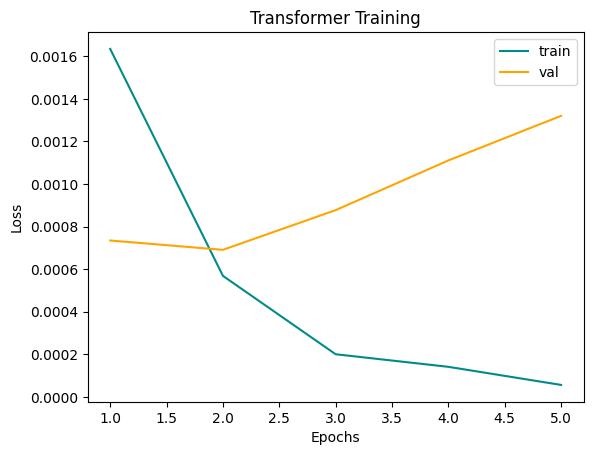

In [50]:
train_losses = training(t_classifier, train_loader, val_loader, 5, 4e-4, 'Transformer Training')

In [164]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = t_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.9979019165039 %
Input sequence: 
 t eran possenti il nome del bel fior ch io sempre invoco e mane e sera tutto mi ristrinse l


# Transformer Classifier Accuracy

In [51]:
with torch.no_grad():
    pred_labels = t_classifier(style0_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

dante_accuracy = 0
for lab in pred_labels:
    if lab.item() == 0:
        dante_accuracy +=1

dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.9858407079646018


In [52]:
with torch.no_grad():
    pred_labels = t_classifier(style1_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

italian_accuracy = 0
for lab in pred_labels:
    if lab.item() == 1:
        italian_accuracy +=1

italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Italian: ', italian_accuracy)

Accuracy predicting Italian:  0.9964601769911504


In [53]:
with torch.no_grad():
    pred_labels = t_classifier(style2_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

neapolitan_accuracy = 0
for lab in pred_labels:
    if lab.item() == 2:
        neapolitan_accuracy +=1

neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Neapolitan: ', neapolitan_accuracy)

Accuracy predicting Neapolitan:  1.0


In [54]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall Transformer Accuracy: ', overall_accuracy)

Overall Transformer Accuracy:  0.9941002949852508
